# validating BGS spectral sims with Blanc exposures
In this notebook, I will validate whether 
- the redshift success rate measured from spectral simulations run with actual observed sky brightness, exposure time, and observing conditions (airmass, seeing) 

can reproduce
- the redshift success rate measured from Blanc observations. 

If the redshift success rate of the BGS spectral sims match the Blanc observations, the BGS spectral sims are good to go. 

In [10]:
!pip install git+https://github.com/desi-bgs/bgs-cmxsv.git --upgrade --user
!pip install git+https://github.com/desi-bgs/feasiBGS.git --upgrade --user

  Cloning https://github.com/desi-bgs/bgs-cmxsv.git to /tmp/pip-req-build-9h8_55ov
  Running command git clone -q https://github.com/desi-bgs/bgs-cmxsv.git /tmp/pip-req-build-9h8_55ov
  Created wheel for bgs-sv: filename=bgs_sv-0.0-py3-none-any.whl size=1086844 sha256=d6e0d6a8c6a165268e089cd0a3743441b63292f3c049b979b4b5a73beed4c10d
  Stored in directory: /tmp/pip-ephem-wheel-cache-ob9zs_rr/wheels/c5/7b/33/3fa8f7338087a37e7ad7a1378e08d97458e5dbab577a10268f
Successfully built bgs-sv
  Attempting uninstall: bgs-sv
    Found existing installation: bgs-sv 0.0
    Uninstalling bgs-sv-0.0:
      Successfully uninstalled bgs-sv-0.0
  Cloning https://github.com/desi-bgs/feasiBGS.git to /tmp/pip-req-build-33wpb2rn
  Running command git clone -q https://github.com/desi-bgs/feasiBGS.git /tmp/pip-req-build-33wpb2rn
  Created wheel for feasibgs: filename=feasibgs-0.1-py3-none-any.whl size=47422 sha256=0d3318c073aa26c20dcda05d8861a745e56ea0ca12a69f0568542442bf3a09b9
  Stored in directory: /tmp/pip-ep

In [16]:
import os
import numpy as np 
import astropy.table as atable
import matplotlib.pyplot as plt

import fitsio

from bgs_sv import sv1
# --- feasibgs --- 
from feasibgs import util as UT
from feasibgs import spectral_sims as BGS_spec_sim
from feasibgs import forwardmodel as FM 

In [12]:
# read in source wavelength, flux, and galaxy properties. 
wave_s, flux_s, prop = BGS_spec_sim.simulated_GAMA_source_spectra(emlines=True) 

# extract true redshift and r-band magnitude for the simulated galaxies
ztrue = prop['zred'] # redshift
r_mag = prop['r_mag'] # Legacy Survey r mag

# run it through the BGS forward model
fdesi = FM.fakeDESIspec()

# read single exposures from Blanc reduction
Rongpu ran redrock on all of the Blanc exposures

In [3]:
exps = sv1.blanc_nexp1_exposures()

In [7]:
is_bgs = (exps['TARGETS'] == 'BGS+MWS') & (exps['GFA_TRANSPARENCY'] > 0.95)
print('%i BGS exposures in Blanc with GFA TRANSP > 0.95' % np.sum(is_bgs))
bgs_exps = exps[is_bgs]

69 BGS exposures in Blanc with GFA TRANSP > 0.95


In [8]:
bgs_exps

NIGHT,EXPID,FIELD,TARGETS,OBSCONDITIONS,ARIZONA_TIMEOBS,EBV,SPECMODEL_SKY_GMAG_AB,SPECMODEL_SKY_RMAG_AB,SPECMODEL_SKY_ZMAG_AB,GFA_ORIGIN,B_DEPTH,R_DEPTH,Z_DEPTH,B_DEPTH_EBVAIR,R_DEPTH_EBVAIR,Z_DEPTH_EBVAIR,DAILY_BITPSFFN,DAILY_BITFRAMEFN,DAILY_BITSKYFN,DAILY_BITSFRAMEFN,DAILY_BITFLUXCALIBFN,DAILY_BITCFRAMEFN,TGT,SKY,STD,WD,LRG,ELG,QSO,BGS,MWS,TILEID,TILERA,TILEDEC,EXPTIME,MJDOBS,SKYMON_NEXP,SKYMON_SKYCAM0_MEAN,SKYMON_SKYCAM0_MEAN_ERR,SKYMON_SKYCAM1_MEAN,SKYMON_SKYCAM1_MEAN_ERR,SKYMON_AVERAGE_MEAN,SKYMON_AVERAGE_MEAN_ERR,GFA_AIRMASS,GFA_MOON_ILLUMINATION,GFA_MOON_ZD_DEG,GFA_MOON_SEP_DEG,GFA_TRANSPARENCY,GFA_FWHM_ASEC,GFA_SKY_MAG_AB,GFA_FIBER_FRACFLUX,GFA_FIBER_FRACFLUX_ELG,GFA_TRANSPFRAC,GFA_MAXCONTRAST,GFA_MINCONTRAST,GFA_KTERM,GFA_RADPROF_FWHM_ASEC,GFA_FIBERFAC,GFA_FIBERFAC_ELG,EPHEM_NOON,EPHEM_DUSK,EPHEM_DAWN,EPHEM_BRIGHTDUSK,EPHEM_BRIGHTDAWN,EPHEM_BRIGHTDUSK_LST,EPHEM_BRIGHTDAWN_LST,EPHEM_MOONRISE,EPHEM_MOONSET,EPHEM_MOON_ILLUM_FRAC,EPHEM_NEAREST_FULL_MOON
int64,int64,bytes30,bytes16,int16,bytes19,float32,float32,float32,float32,bytes13,float32,float32,float32,float32,float32,float32,int64,int64,int64,int64,int64,int64,int16,int16,int16,int16,int16,int16,int16,int16,int16,int64,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
20201218,68619,Pegasus2,BGS+MWS,2,2020-12-18T21:12:32,0.036,22.450108,21.61949,20.074186,matched_coadd,243.3,262.9,317.1,184.18425,219.4316,286.78424,1073741823,1073741823,1073741823,1073741823,1065345015,1065345015,4199,800,226,10,575,12,7,3087,1064,80617,5.0,28.0,300.0,59202.176,0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,1.1651487,0.23516595,84.38169,55.935997,0.97983116,1.212625,20.8002,0.48197633,0.361744,0.47225544,12.498982,6.49888,0.114,1.2677754,0.8130784,0.8478083,59201.791666666664,59202.07819552423,59202.53794256821,59202.05746491799,59202.55867547271,-2.8037748348945115,178.12604437096692,59201.74867241028,59202.201215020024,0.24614796278654827,10.852906347514363
20201218,68644,Eridanus,BGS+MWS,1,2020-12-18T22:23:25,0.04,22.836369,21.856005,20.133734,matched_coadd,408.8,405.3,426.2,290.85605,326.5219,377.84415,1073741823,1073741823,1073741823,1073741823,1073741823,1073741823,4199,800,230,11,631,33,9,3279,869,80612,66.68,-5.24,300.0,59202.223,0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,1.2701076,0.2395255,97.90488,94.106224,1.0039129,1.095246,20.923965,0.5286667,0.39003545,0.5307353,13.475483,7.884813,0.114,1.1117882,0.90839875,0.9343531,59201.791666666664,59202.07819552423,59202.53794256821,59202.05746491799,59202.55867547271,-2.8037748348945115,178.12604437096692,59201.74867241028,59202.201215020024,0.24614796278654827,10.852906347514363
20201218,68645,Eridanus,BGS+MWS,1,2020-12-18T22:33:22,0.04,22.837118,21.820581,20.057423,matched_coadd,396.9,379.5,388.5,283.13776,306.13528,344.67874,1073741823,1073741823,1073741823,1073741823,1073741823,1073741823,4199,800,230,11,631,33,9,3279,869,80612,66.68,-5.24,300.0,59202.23,0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,1.2627392,0.24014096,99.86736,94.026,1.009208,1.1085556,21.449928,0.519399,0.38396025,0.52418166,9.681183,7.5843024,0.114,1.1330372,0.89439446,0.91711926,59201.791666666664,59202.07819552423,59202.53794256821,59202.05746491799,59202.55867547271,-2.8037748348945115,178.12604437096692,59201.74867241028,59202.201215020024,0.24614796278654827,10.852906347514363
20201218,68646,Eridanus,BGS+MWS,1,2020-12-18T22:43:18,0.04,22.849367,21.837626,20.087267,matched_coadd,297.1,285.6,295.1,212.30339,230.5807,261.93933,1073741823,1073741823,1073741823,1073741823,1073741823,1073741823,4199,800,230,11,631,33,9,3279,869,80612,66.68,-5.24,300.0,59202.24,0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,1.258011,0.24075274,101.82761,93.94574,0.9945988,1.2483656,21.413948,0.45328766,0.343347,0.45083934,11.589305,8.422351,0.114,1.246526

In [9]:
# observing conditions from median value of the GFAs
airmass = bgs_exps['GFA_AIRMASS']
moon_frac = bgs_exps['GFA_MOON_ILLUMINATION']
moon_sep = bgs_exps['GFA_MOON_SEP_DEG']
moon_alt = 90. - bgs_exps['GFA_MOON_ZD_DEG']
transp = bgs_exps['GFA_TRANSPARENCY']

# Construct BGS spectral sims
Run BGS spectral sims with: 
- sky brightness
- exposure time
- airmass
- seeing

directly from observations

In [50]:
for i in np.arange(len(bgs_exps))[::10]: 
    wave, Isky = sv1.get_obs_sky(int(bgs_exps[i]['NIGHT']), int(bgs_exps[i]['EXPID']), 'model', redux="daily");
    Isky *= 1e17 
    
    fspec = '/global/cfs/cdirs/desi/users/chahah/bgs_spectral_sim.tile%i_exp%i.fits' % (bgs_exps[i]['TILEID'], bgs_exps[i]['EXPID'])

    if not os.path.isfile(fspec): 
        print('constructing %s' % fspec)
        bgs = fdesi.simExposure(
            wave_s, 
            flux_s, 
            exptime=bgs_exps['EXPTIME'][i], 
            airmass=bgs_exps['GFA_AIRMASS'][i],
            seeing=bgs_exps['GFA_FWHM_ASEC'][i],
            Isky=[wave, np.clip(Isky, 0, None)], 
            filename=fspec
        )
    else: 
        from desispec.io.spectra import read_spectra
        bgs = read_spectra(fspec)        
        print(bgs.ivar['b'][0])

INFO:spectra.py:253:read_spectra: iotime 1.099 sec to read bgs_spectral_sim.tile80617_exp68619.fits at 2021-02-24T15:05:26.853027
[0.10325176 0.10401402 0.10478856 ... 0.00128406 0.00126819 0.00125975]
INFO:spectra.py:253:read_spectra: iotime 1.288 sec to read bgs_spectral_sim.tile80612_exp68644.fits at 2021-02-24T15:05:32.091881
[0.09283804 0.09353399 0.09424118 ... 0.00124938 0.00123421 0.00122669]
INFO:spectra.py:253:read_spectra: iotime 1.187 sec to read bgs_spectral_sim.tile80612_exp68645.fits at 2021-02-24T15:05:36.962806
[0.09353375 0.09423418 0.09494591 ... 0.00125153 0.00123629 0.00122872]
INFO:spectra.py:253:read_spectra: iotime 1.188 sec to read bgs_spectral_sim.tile80612_exp68646.fits at 2021-02-24T15:05:41.991147
[0.09398291 0.09468621 0.09540087 ... 0.00125329 0.00123797 0.00123036]
INFO:spectra.py:253:read_spectra: iotime 1.160 sec to read bgs_spectral_sim.tile80613_exp68657.fits at 2021-02-24T15:05:46.894164
[0.0961024  0.09681927 0.09754772 ... 0.00126055 0.00124508 0.

KeyboardInterrupt: 

## run redrock for each of the BGS spectral simulations

In [43]:
for i in np.arange(len(bgs_exps)): 
    f_spec = '/global/cfs/cdirs/desi/users/chahah/bgs_spectral_sim.tile%i_exp%i.fits' % (bgs_exps[i]['TILEID'], bgs_exps[i]['EXPID'])
    f_rr_h5 = '/global/cfs/cdirs/desi/users/chahah/redrock.bgs_spectral_sim.tile%i_exp%i.h5' % (bgs_exps[i]['TILEID'], bgs_exps[i]['EXPID'])
    f_rr = '/global/cfs/cdirs/desi/users/chahah/redrock.bgs_spectral_sim.tile%i_exp%i.fits' % (bgs_exps[i]['TILEID'], bgs_exps[i]['EXPID'])
    if not os.path.isfile(f_rr): 
        print('constructing %s' % f_rr)
        !rrdesi -o $f_rr_h5 -z $f_rr $f_spec

constructing /global/cfs/cdirs/desi/users/chahah/redrock.bgs_spectral_sim.tile80618_exp69238.fits
Running on a NERSC login node- reducing number of processes to 4
Running with 4 processes
Loading targets...
Read and distribution of 1000 targets: 8.2 seconds
DEBUG: Read templates from /global/cscratch1/sd/chahah/redrock-templates
DEBUG: Using default redshift range -0.0050-1.6997 for rrtemplate-galaxy.fits
DEBUG: Using default redshift range 0.0500-5.9934 for rrtemplate-qso.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-A.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-B.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-CV.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-F.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-G.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-K.fits
DEBUG: Using default redshift range -0.0020-0.00

functions to calculate redshift success rate of Blanc observations

In [44]:
def zsuccess_redrock_criteria(zbest): 
    ''' redshift success criteria based only on redrock output
    '''
    crit_zwarn = (zbest['ZWARN'] == 0)
    crit_dchi2 = (zbest['DELTACHI2']  > 40.) 
    crit_stype = (zbest['SPECTYPE'] != "STAR") # only galaxy spectra
    crit_z_lim = (zbest['Z'] > 0.0) & (zbest['Z'] < 0.6) # rough BGS redshift limit
    crit_z_err = (zbest['ZERR'] < (0.0005 * (1. + zbest['Z'])))

    # combine all criteria
    zsuccess = crit_zwarn & crit_dchi2 & crit_stype & crit_z_lim & crit_z_err
    return zsuccess

def get_exp_rmag_zsucess(tileid, night, expid): 
    # only use targets where we have accurate redshifts in the deep exposure
    _zbest_deep = sv1.get_zbest(tileid, 'deep', targetclass='brightfaint')
    zs_deep = zsuccess_redrock_criteria(_zbest_deep)

    zbest_deep = _zbest_deep[zs_deep]['TARGETID', 'Z']
    zbest_deep.rename_column('Z', 'Z_TRUE') # deep exposure redshift is the "true redshift"
    
    _zbest_exp = sv1.get_zbest(tileid, night, expid=expid, targetclass='brightfaint')
    zbest_exp = atable.join(zbest_deep, _zbest_exp, keys='TARGETID', join_type='left')
    
    r_mag = 22.5 - 2.5 * np.log10(zbest_exp['FLUX_R']) 
    # calculate redshift successs rate
    return r_mag, UT.zsuccess(zbest_exp['Z'], zbest_exp['Z_TRUE'], zbest_exp['ZWARN'], deltachi2=zbest_exp['DELTACHI2'], min_deltachi2=40)

In [45]:
# compile redshift success rates
zs_sim, rmag_blanc, zs_blanc = [], [], [] 
for i in np.arange(len(bgs_exps))[::10]: 
    f_rr_sim = '/global/cfs/cdirs/desi/users/chahah/redrock.bgs_spectral_sim.tile%i_exp%i.fits' % (bgs_exps[i]['TILEID'], bgs_exps[i]['EXPID'])
    rr_sim = fitsio.read(f_rr_sim)
    
    # redshift success defined as |z_redrock - z_true|/(1+z_true) < 0.003 and ZWARN flag = 0 
    _zs_sim = UT.zsuccess(rr_sim['Z'], ztrue, rr_sim['ZWARN'], deltachi2=rr_sim['DELTACHI2'], min_deltachi2=40)
    zs_sim.append(_zs_sim)
    
    _rmag_blanc, _zs_blanc = get_exp_rmag_zsucess(bgs_exps['TILEID'][i], bgs_exps['NIGHT'][i], bgs_exps['EXPID'][i])
    rmag_blanc.append(_rmag_blanc)
    zs_blanc.append(_zs_blanc)

 /global/cfs/cdirs/desi/spectro/redux/blanc/tiles/80617/exposures/zbest-3-80617-00068619.fits does not exist


Text(0, 0.5, 'redshift success rate')

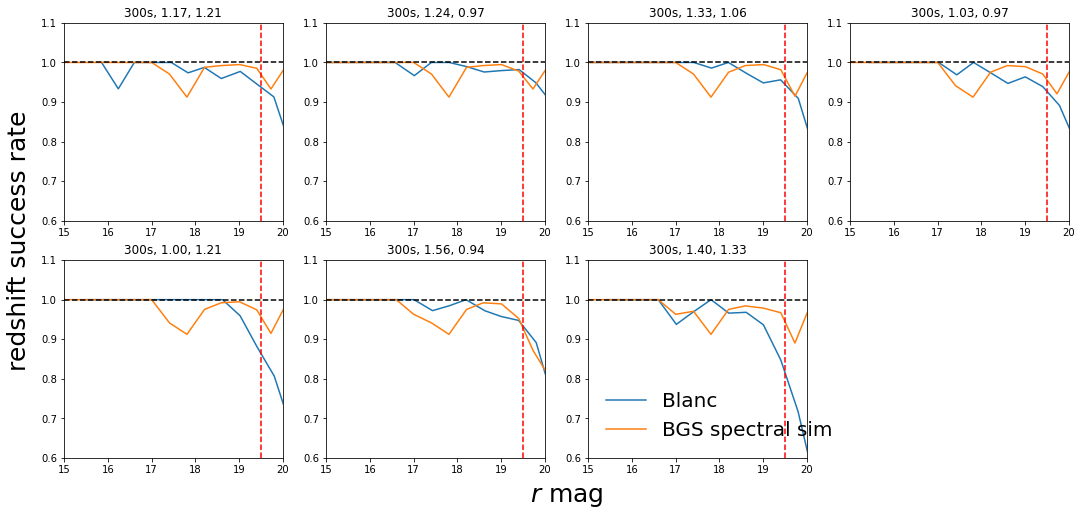

In [52]:
fig = plt.figure(figsize=(18,8))
for i, iexp, _rmag_blanc, _zs_sim, _zs_blanc in zip(range(len(zs_sim)), np.arange(len(bgs_exps))[::10], rmag_blanc, zs_sim, zs_blanc):     
    sub = fig.add_subplot(2,4,i+1)
    r_mid, zs, zs_err = UT.zsuccess_rate(_rmag_blanc, _zs_blanc, range=(14, 22), nbins=20)
    sub.plot(r_mid, zs, c='C0', label='Blanc')
    r_mid, zs, zs_err = UT.zsuccess_rate(r_mag, _zs_sim, range=(14, 22), nbins=20)
    sub.plot(r_mid, zs, c='C1', label='BGS spectral sim')
    sub.plot([15., 20.], [1., 1.], c='k', ls='--')
    sub.axvline(19.5, c='r', ls='--')
    sub.set_xlim(15, 20)
    sub.set_ylim(0.6, 1.1)
    sub.set_title('%.fs, %.2f, %.2f' % (bgs_exps['EXPTIME'][iexp], bgs_exps['GFA_AIRMASS'][iexp], bgs_exps['GFA_FWHM_ASEC'][iexp]))

sub.legend(loc='lower left', fontsize=20, frameon=False) 
bkgd = fig.add_subplot(111, frameon=False)
bkgd.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
bkgd.set_xlabel(r'$r$ mag', labelpad=10, fontsize=25) 
bkgd.set_ylabel('redshift success rate', labelpad=10, fontsize=25) 

Spectral simulations are reasonably accurate for good seeing, but deviate significant for bad 